In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Liberation Serif'

import logging
import pickle
from datetime import datetime
import os
from data_processing import gen_ckpt_steps
from conv_plots_funcs import get_seg_starts_per_config
import torch
import gc
from core.config import Config
from data_train import set_config_params, gen_ckpt_pred_steps

In [7]:
config = Config()
model_name = "ortho_haar_medium_single_gpu"

output_dir, ckpt_dir, experiment_name = set_config_params(config, model_name)

datasource = "val"


colors = ['#000000', '#005CAB', '#E31B23', '#FFC325', '#00A651', '#9B59B6']



ORTHO HAAR MEDIUM MODEL 1 GPU




len(full_range) 181
ckpt 1000 not found
ckpt 2000 not found
ckpt 3000 not found
tf_errs.shape: (100, 1000, 251)
zero_errs.shape: (100, 1000, 251)



ckpt: 4000
tf_errs_med_trial.shape: (100, 251)
zero_errs_med_trial.shape: (100, 251)
tf_errs_med.shape: (251,)
ckpt 5000 not found
ckpt 6000 not found
ckpt 7000 not found
tf_errs.shape: (100, 1000, 251)
zero_errs.shape: (100, 1000, 251)



ckpt: 8000
tf_errs_med_trial.shape: (100, 251)
zero_errs_med_trial.shape: (100, 251)
tf_errs_med.shape: (251,)
ckpt 9000 not found
ckpt 10000 not found
ckpt 11000 not found
tf_errs.shape: (100, 1000, 251)
zero_errs.shape: (100, 1000, 251)



ckpt: 12000
tf_errs_med_trial.shape: (100, 251)
zero_errs_med_trial.shape: (100, 251)
tf_errs_med.shape: (251,)
ckpt 13000 not found
ckpt 14000 not found
ckpt 15000 not found
ckpt 16000 not found
ckpt 17000 not found
ckpt 18000 not found
ckpt 19000 not found
ckpt 20000 not found
tf_errs.shape: (100, 1000, 251)
zero_errs.shape: (100, 1000, 251)



ckpt: 21000
tf_errs_

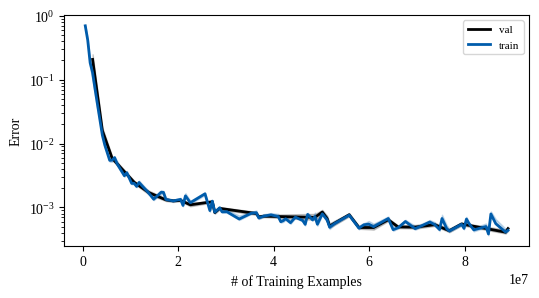

In [34]:
ckpt_steps = gen_ckpt_pred_steps(model_name)

fig,ax = plt.subplots(1, 1, figsize=(6, 3))

count = 0

datasources = ["val", "train"]
tf_quartiles_cong = []
zero_quartiles_cong = []
train_exs_cong = []
for datasource in datasources:
    train_exs = []
    tf_quartiles_lst = []
    zero_quartiles_lst = []

    for ckpt in np.arange(1000, 182000, 1000):

        train_ex = ckpt*len(config.devices)*config.batch_size

        path = f"{output_dir}/prediction_errors{config.C_dist}_step={ckpt}.ckpt/train_conv_mult_cut_{datasource}_ortho_haar_state_dim_5_err_lss_examples.pkl"

        try:
            with open(path, "rb") as f:
                data = pickle.load(f)
                tf_errs = data["MOP"][0]
                zero_errs = data["Zero"][0]

                print(f"tf_errs.shape: {tf_errs.shape}")
                print(f"zero_errs.shape: {zero_errs.shape}")

                #set all np.inf to 0 in tf_errs and zero_errs
                tf_errs[np.isinf(tf_errs)] = 0
                zero_errs[np.isinf(zero_errs)] = 0


        except FileNotFoundError:
            print(f"ckpt {ckpt} not found")
            continue

        print(f"\n\n\nckpt: {ckpt}")
        tf_errs_med_trial = np.median(tf_errs, axis=1)
        zero_errs_med_trial = np.median(zero_errs, axis=1)
        print(f"tf_errs_med_trial.shape: {tf_errs_med_trial.shape}")
        print(f"zero_errs_med_trial.shape: {zero_errs_med_trial.shape}")

        tf_errs_med = np.median(tf_errs_med_trial, axis=0)
        zero_errs_med = np.median(zero_errs_med_trial, axis=0)
        print(f"tf_errs_med.shape: {tf_errs_med.shape}")

        tf_quartiles = np.quantile(tf_errs_med, [0.25, 0.5, 0.75], axis=0)
        zero_quartiles = np.quantile(zero_errs_med, [0.25, 0.5, 0.75], axis=0)

        tf_quartiles_lst.append(tf_quartiles)
        zero_quartiles_lst.append(zero_quartiles)
        train_exs.append(train_ex)



    ax.plot(train_exs, [tf_quartiles[1] for tf_quartiles in tf_quartiles_lst], color=colors[count], linewidth=2, label={datasource}, markersize=5)
    ax.fill_between(train_exs, [tf_quartiles[0] for tf_quartiles in tf_quartiles_lst], [tf_quartiles[2] for tf_quartiles in tf_quartiles_lst], color=colors[count], alpha=0.2)

    tf_quartiles_cong.append(tf_quartiles_lst)
    zero_quartiles_cong.append(zero_quartiles_lst)
    train_exs_cong.append(train_exs)
    count += 1


ax.set_ylabel("Error")
ax.set_xlabel("# of Training Examples")
ax.set_yscale("log")
ax.legend(loc="upper right", fontsize=8)


plt.show()


len(tf_quartiles_cong): 2


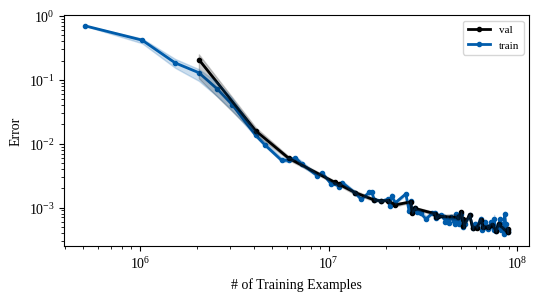

In [41]:
fig,ax = plt.subplots(1, 1, figsize=(6, 3))
count = 0

print(f"len(tf_quartiles_cong): {len(tf_quartiles_cong)}")
for tf_quartiles_lst, zero_quartiles_lst, train_exs in zip(tf_quartiles_cong, zero_quartiles_cong, train_exs_cong):

    ax.plot(train_exs, [tf_quartiles[1] for tf_quartiles in tf_quartiles_lst], color=colors[count], linewidth=2, label={datasources[count]}, marker="o", markersize=3, zorder=1-count)

    ax.fill_between(train_exs, [tf_quartiles[0] for tf_quartiles in tf_quartiles_lst], [tf_quartiles[2] for tf_quartiles in tf_quartiles_lst], color=colors[count], alpha=0.2)
    count += 1


ax.set_ylabel("Error")
ax.set_xlabel("# of Training Examples")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(loc="upper right", fontsize=8)


plt.show()